In [2]:
import pickle, os

In [5]:
std_false_file = r"C:\Users\lh\Downloads\first_batch_stdFalse.pkl"
std_true_file = r"C:\Users\lh\Downloads\first_batch_stdTrue.pkl"

检查是否标准化

In [10]:
x_false, y_false, std = pickle.load(open(std_false_file, 'rb'))
x_true, y_true = pickle.load(open(std_true_file, 'rb'))

In [9]:
(y_false == y_true).all()

tensor(True)

In [20]:
_x = x_false[0][:650].reshape([50, 650 // 50])
((_x - std[0][:, 0]) / std[0][:, 1] == x_true[0][:650].reshape([50, 650 // 50])).all()

tensor(True)

In [127]:
x_false[0][-4:], x_true[0][-4:]

(tensor([9.0000e+00, 3.2980e-02, 0.0000e+00, 1.2840e+04]),
 tensor([9.0000e+00, 3.2980e-02, 0.0000e+00, 1.2840e+04]))

可视化

In [99]:
sample_idx = 0

样本索引: 35
513120(8) 当前: 空仓 2024-01-17 14:09:23
D:\L2_DATA_T0_ETF\his_data\20240117\513120\十档盘口.csv
样本索引: 1705471763
样本索引: 4135 - 4185
样本时间: 2024-01-17 14:06:56 - 2024-01-17 14:09:23
标签:空仓


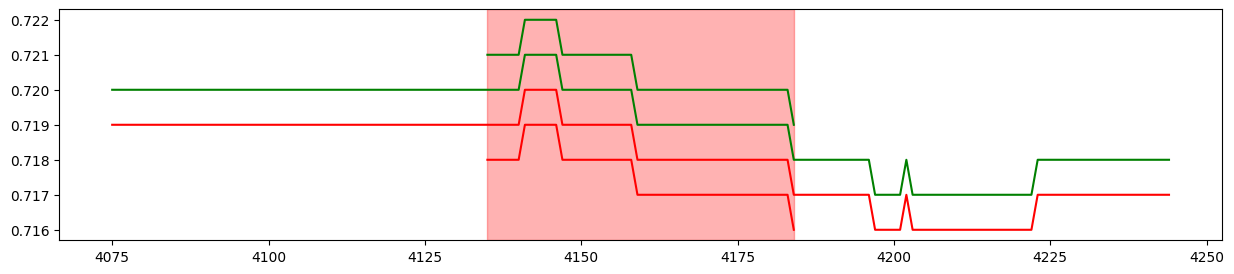

In [138]:
# 解析数据归属
from dl_helper.rl.rl_utils import date2days, days2date
from dl_helper.rl.rl_env.lob_trade.lob_const import USE_CODES, MAX_SEC_BEFORE_CLOSE
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# sample_idx = 32
print(f'样本索引: {sample_idx}')

_sample_date = days2date(int(x_false[sample_idx][-1]))
_sample_pos = int(x_false[sample_idx][-2])
_sample_sec = x_false[sample_idx][-3] * MAX_SEC_BEFORE_CLOSE
close_dt = datetime.strptime(f'{_sample_date} 15:00:00', '%Y%m%d %H:%M:%S')
_sample_dt = close_dt - timedelta(seconds=int(_sample_sec))
_sample_symbol_id = int(x_false[sample_idx][-4])
_sample_synbol = USE_CODES[_sample_symbol_id]
_sample_y = y_false[sample_idx]

_sample_synbol, _sample_date, _sample_pos, _sample_dt
print(f'{_sample_synbol}({int(_sample_symbol_id)}) 当前: '+ (f'持仓' if _sample_pos==1 else '空仓') + f' {_sample_dt}')

# 读取原始数据
lob_file = rf"D:\L2_DATA_T0_ETF\his_data\{_sample_date}\{_sample_synbol}\十档盘口.csv"
print(lob_file)
_data = pd.read_csv(lob_file, encoding='gbk')
# 删除完全重复的行
_data = _data.drop_duplicates(keep='first')
_data = _data[['时间', '卖1价', '买1价']]

# 匹配样本 时点
idx = 0
# 2. 显式标记为北京时间（UTC+8）
dt = pd.to_datetime(_data['时间'])
dt = dt.dt.tz_localize('Asia/Shanghai')  # 北京时间
ts = dt.apply(lambda x: int(x.timestamp()))
_sample_ts = int(_sample_dt.timestamp())
print(f'样本索引: {_sample_ts}')
for _idx, _t in enumerate(ts):
    if _t >= _sample_ts:
        if _t == _sample_ts:
            # 完美匹配
            idx = _idx
        else:
            # 使用距离最近的点
            _pre_ts = ts[_idx-1]
            _cur_ts = _t
            if abs(int(_pre_ts) - int(_sample_ts)) > abs(int(_cur_ts) - int(_sample_ts)):
                idx = _idx
            else:
                idx = _idx - 1
        break

_data.columns = ['time', 'ask', 'bid']

i_begin, i_end = idx-50+1, idx+1

print(f'样本索引: {i_begin} - {i_end}')
data_range = _data.iloc[i_begin: i_end]
print(f'样本时间: {data_range["time"].iloc[0]} - {data_range["time"].iloc[-1]}')

ext_len = 60
ext_begin, ext_end = i_begin-ext_len, i_end+ext_len
ext_data = _data.iloc[ext_begin: ext_end]

print('标签:' + (f'持仓' if _sample_y==0 else '空仓'))

# 构造样本的数据
s_ask = ext_data['ask'].copy().values
s_bid = ext_data['bid'].copy().values
_x = x_false[sample_idx][:650].reshape([50, 650 // 50])
s_len = _x.shape[0]
s_ask[:ext_len] = np.nan
s_bid[:ext_len] = np.nan
s_ask[-ext_len:] = np.nan
s_bid[-ext_len:] = np.nan
s_ask[ext_len: -ext_len] = np.asarray(_x[:, 0])
s_bid[ext_len: -ext_len] = np.asarray(_x[:, 2])

fig, ax = plt.subplots(figsize=(15, 3))
plt.plot(ext_data.index, ext_data['ask'], label='Ask', color='green')
plt.plot(ext_data.index, s_ask+0.001, label='sAsk', color='green')
plt.plot(ext_data.index, ext_data['bid'], label='Bid', color='red')
plt.plot(ext_data.index, s_bid-0.001, label='sBid', color='red')
plt.axvspan(i_begin, i_end - 1, color='red', alpha=0.3)

sample_idx += 1